In [127]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
from wordcloud import WordCloud
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score

In [2]:
df = pd.read_csv("Womens Clothing E-Commerce Reviews.csv", index_col=0)

In [3]:
df.head()

,Clothing ID,Age,Title,Review Text,Rating,Recommended IND,Positive Feedback Count,Division Name,Department Name,Class Name
0,767,33,NaN,Absolutely wonderful - silky and sexy and comf...,4,1,0,Initmates,Intimate,Intimates
1,1080,34,NaN,Love this dress! it's sooo pretty. i happene...,5,1,4,General,Dresses,Dresses
2,1077,60,Some major design flaws,I had such high hopes for this dress and reall...,3,0,0,General,Dresses,Dresses
3,1049,50,My favorite buy!,"I love, love, love this jumpsuit. it's fun, fl...",5,1,0,General Petite,Bottoms,Pants
4,847,47,Flattering shirt,This shirt is very flattering to all due to th...,5,1,6,General,Tops,Blouses


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 23486 entries, 0 to 23485
Data columns (total 10 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   Clothing ID              23486 non-null  int64 
 1   Age                      23486 non-null  int64 
 2   Title                    19676 non-null  object
 3   Review Text              22641 non-null  object
 4   Rating                   23486 non-null  int64 
 5   Recommended IND          23486 non-null  int64 
 6   Positive Feedback Count  23486 non-null  int64 
 7   Division Name            23472 non-null  object
 8   Department Name          23472 non-null  object
 9   Class Name               23472 non-null  object
dtypes: int64(5), object(5)
memory usage: 2.0+ MB


In [5]:
df.shape

(23486, 10)

In [6]:
review = df[["Review Text", "Recommended IND"]]

In [7]:
review = review.rename(columns={"Recommended IND": "Recommended", "Review Text": "Review"})

Text(0.5, 1.0, 'Proportion Target Class')

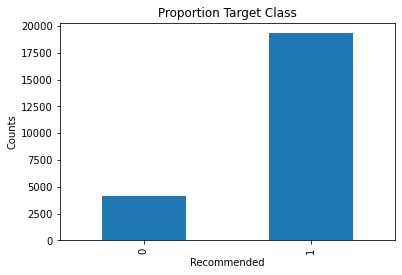

In [8]:
review["Recommended"].value_counts().plot(kind="bar")
plt.xlabel("Recommended")
plt.ylabel("Counts")
plt.title("Proportion Target Class")

In [9]:
review.isnull().sum()

Review         845
Recommended      0
dtype: int64

In [10]:
# Let's drop the null values.

In [11]:
review.dropna(inplace=True)

In [12]:
review.isnull().sum()

Review         0
Recommended    0
dtype: int64

In [13]:
review.shape

(22641, 2)

In [14]:
# Tokenization, noise removal and lexicon normalization

In [15]:
def cleaning(data):
    # 1. Tokenize
    text_tokens = word_tokenize(data.lower())
    # 2. Remove punctuations
    tokens_without_punc = [w for w in text_tokens if w.isalpha()]
    # 3. Remove stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]
    # 4. Lemmatization
    text_cleaned = [lem.lemmatize(t) for t in tokens_without_sw]
    # 5. Join
    return " ".join(text_cleaned)

In [16]:
stop_words = stopwords.words("english")
lem = WordNetLemmatizer()

In [17]:
review["Review"] = review.Review.apply(cleaning)

In [18]:
review.head()

,Review,Recommended
0,absolutely wonderful silky sexy comfortable,1
1,love dress sooo pretty happened find store gla...,1
2,high hope dress really wanted work initially o...,0
3,love love love jumpsuit fun flirty fabulous ev...,1
4,shirt flattering due adjustable front tie perf...,1


In [19]:
# WordCloud

In [20]:
positive = review[review.Recommended == 1]
negative = review[review.Recommended == 0]

In [21]:
negative.head()

,Review,Recommended
2,high hope dress really wanted work initially o...,0
5,love tracy reese dress one petite foot tall us...,0
10,dress run small esp zipper area run ordered sp...,0
22,first pullover styling side zipper would purch...,0
25,loved material didnt really look long dress pu...,0


In [22]:
positive.head()

,Review,Recommended
0,absolutely wonderful silky sexy comfortable,1
1,love dress sooo pretty happened find store gla...,1
3,love love love jumpsuit fun flirty fabulous ev...,1
4,shirt flattering due adjustable front tie perf...,1
6,aded basket hte last mintue see would look lik...,1


In [23]:
positive_words = []

positive.Review.apply(lambda x: positive_words.append(x))

0        None
1        None
3        None
4        None
6        None
         ... 
23479    None
23481    None
23482    None
23484    None
23485    None
Name: Review, Length: 18540, dtype: object

In [24]:
positive_words = " ".join(positive_words)

In [25]:
positive_words[:200]

'absolutely wonderful silky sexy comfortable love dress sooo pretty happened find store glad bc never would ordered online bc petite bought petite love length hit little knee would definitely true midi'

In [26]:
negative_words = []

negative.Review.apply(lambda x: negative_words.append(x))

2        None
5        None
10       None
22       None
25       None
         ... 
23449    None
23450    None
23460    None
23478    None
23483    None
Name: Review, Length: 4101, dtype: object

In [27]:
negative_words = " ".join(negative_words)

In [28]:
negative_words[:200]

'high hope dress really wanted work initially ordered petite small usual size found outrageously small small fact could zip reordered petite medium overall top half comfortable fit nicely bottom half t'

In [29]:
len(positive_words.split())

510172

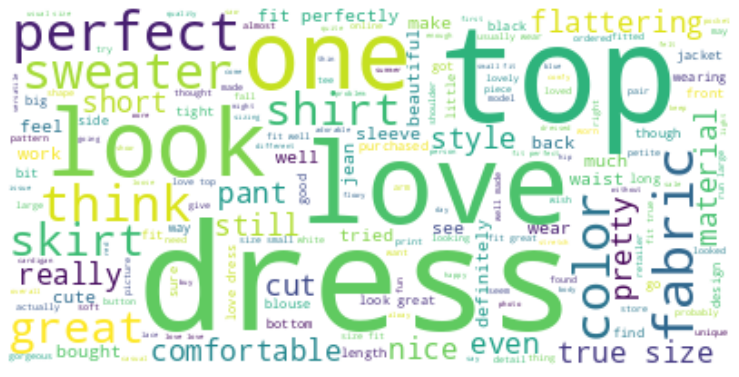

In [30]:
wordcloud = WordCloud(background_color="white", max_words=len(positive_words.split()))

wordcloud.generate(positive_words)

plt.figure(figsize=(13, 13))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

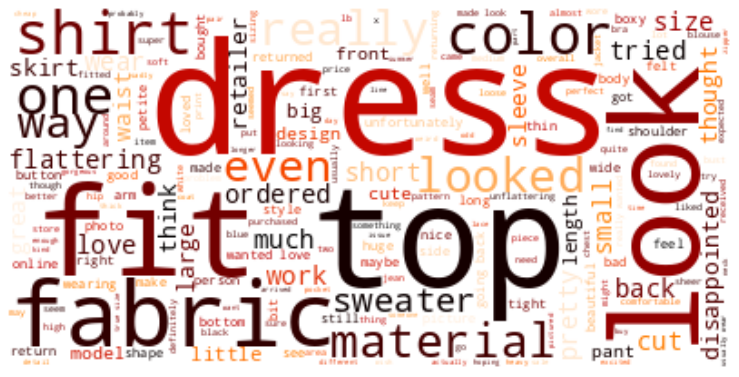

In [31]:
wordcloud = WordCloud(background_color="white", max_words=len(negative_words.split()), colormap="gist_heat")

wordcloud.generate(negative_words)

plt.figure(figsize=(13, 13))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [32]:
# Sentiment classification with machine learning.

In [33]:
X = review["Review"]
y = review["Recommended"]

In [34]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [35]:
X_train.head()

11811    top look better hanger looking feminine plaid ...
8171     much question whether love pant several pair p...
22106    legging warm comfortable thick enough wear pan...
7473                     much lower quality robe purchased
19698    arrived white store airy dreamy try epitome ef...
Name: Review, dtype: object

In [36]:
# Vectorization

In [37]:
vectorizer = CountVectorizer()

In [38]:
X_train_count = vectorizer.fit_transform(X_train)
X_test_count = vectorizer.transform(X_test)

In [39]:
pd.DataFrame(X_train_count.toarray()).head()

,0,1,2,3,4,5,6,7,8,9,...,10796,10797,10798,10799,10800,10801,10802,10803,10804,10805
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [40]:
# Vectorization with TF-IDF

In [41]:
tf_idf_word_vectorizer = TfidfVectorizer()

In [42]:
X_train_tf_idf = tf_idf_word_vectorizer.fit_transform(X_train)
X_test_tf_idf = tf_idf_word_vectorizer.transform(X_test)

In [43]:
pd.DataFrame(X_train_tf_idf.toarray()).head()

,0,1,2,3,4,5,6,7,8,9,...,10796,10797,10798,10799,10800,10801,10802,10803,10804,10805
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
# Classification with a Linear Model: Logistic Regression

In [45]:
model = LogisticRegression(max_iter=500000, n_jobs=-1)

In [46]:
model.fit(X_train_count, y_train)

LogisticRegression(max_iter=500000, n_jobs=-1)

In [47]:
y_pred = model.predict(X_test_count)

In [48]:
log_count_acc = cross_val_score(model, X_test_count, y_test, cv=10).mean()

In [49]:
log_count_acc

0.8719387954443338

In [50]:
log_count_f1 = f1_score(y_test, y_pred, average="weighted")  # We chose weighted as our average parameter because our dataset is highly inbalanced.
log_count_f1

0.8875088886757424

<AxesSubplot:>

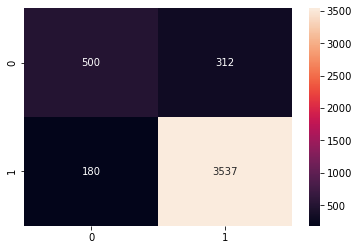

In [51]:
cnf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cnf_matrix, annot=True, fmt="d")

In [52]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.62      0.67       812
           1       0.92      0.95      0.93      3717

    accuracy                           0.89      4529
   macro avg       0.83      0.78      0.80      4529
weighted avg       0.89      0.89      0.89      4529



In [53]:
# Let's try Logistic Regression with TF-IDF vectorization.

In [54]:
model = LogisticRegression(max_iter=500000, n_jobs=-1)

In [55]:
model.fit(X_train_tf_idf, y_train)

LogisticRegression(max_iter=500000, n_jobs=-1)

In [56]:
log_tf_acc = cross_val_score(model, X_test_tf_idf, y_test, cv=10).mean()
log_tf_acc

0.8653128601848052

In [57]:
y_pred = model.predict(X_test_tf_idf)

<AxesSubplot:>

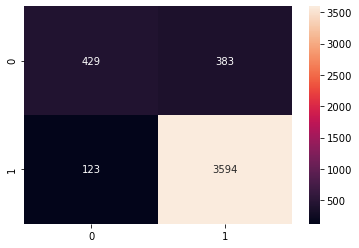

In [58]:
cnf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cnf_matrix, annot=True, fmt="d")

In [59]:
log_tf_f1 = f1_score(y_test, y_pred, average="weighted")
log_tf_f1

0.8795150613058477

In [60]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.78      0.53      0.63       812
           1       0.90      0.97      0.93      3717

    accuracy                           0.89      4529
   macro avg       0.84      0.75      0.78      4529
weighted avg       0.88      0.89      0.88      4529



In [61]:
# Logistic Regression with Count Vectorizer performed better at classifying 0 values correctly than Logistic Regression with TF-IDF vectorizer.

In [62]:
# Naive Bayes Classifier with Count Vectorizer

In [63]:
model = MultinomialNB()

In [64]:
model.fit(X_train_count, y_train)

MultinomialNB()

In [65]:
nb_count_acc = cross_val_score(model, X_test_count, y_test, cv=10).mean()

In [66]:
nb_count_acc

0.861118599699154

In [67]:
y_pred = model.predict(X_test_count)

<AxesSubplot:>

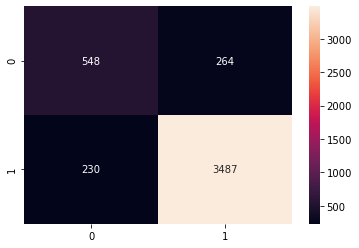

In [68]:
cnf_matrix=confusion_matrix(y_test, y_pred)
sns.heatmap(cnf_matrix, annot=True, fmt="d")

In [69]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.70      0.67      0.69       812
           1       0.93      0.94      0.93      3717

    accuracy                           0.89      4529
   macro avg       0.82      0.81      0.81      4529
weighted avg       0.89      0.89      0.89      4529



In [70]:
# Naive Bayes' performance has been the best in classifying 0 values so far.

In [71]:
# Naive Bayes with TF-IDF Vectorizer

In [72]:
model = MultinomialNB()

In [73]:
model.fit(X_train_tf_idf, y_train)

MultinomialNB()

In [74]:
nb_tf_acc = cross_val_score(model, X_test_tf_idf, y_test, cv=10).mean()

In [75]:
nb_tf_acc

0.8207109925960655

In [76]:
y_pred = model.predict(X_test_tf_idf)

<AxesSubplot:>

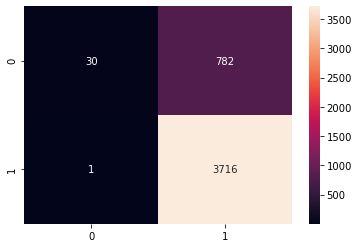

In [77]:
cnf_matrix=confusion_matrix(y_test, y_pred)
sns.heatmap(cnf_matrix, annot=True, fmt="d")

In [78]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.04      0.07       812
           1       0.83      1.00      0.90      3717

    accuracy                           0.83      4529
   macro avg       0.90      0.52      0.49      4529
weighted avg       0.85      0.83      0.76      4529



In [79]:
# Naive Bayes with TF-IDF Vectorizer performed extremely poorly in classifying 0 values.

In [80]:
# Support Vector Machine with Count Vectorizer

In [81]:
model = SVC()

In [82]:
model.fit(X_train_count, y_train)

SVC()

In [83]:
svm_count_acc = cross_val_score(model, X_test_count, y_test, cv=10).mean()

In [84]:
svm_count_acc

0.8686270487800114

In [85]:
y_pred = model.predict(X_test_count)

<AxesSubplot:>

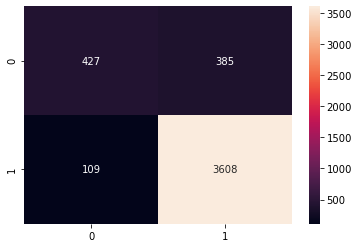

In [86]:
cnf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cnf_matrix, annot=True, fmt="d")

In [87]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.53      0.63       812
           1       0.90      0.97      0.94      3717

    accuracy                           0.89      4529
   macro avg       0.85      0.75      0.78      4529
weighted avg       0.88      0.89      0.88      4529



In [88]:
# SVM with Count Vectorizer performed worse in classifying 0 values than Logistic Regression with Count Vectorizer, however, it performed better than 
# all the other methods we've tried so far when it comes to classifying 1 values.

In [89]:
# SVM with TF-IDF vectorizer

In [90]:
model = SVC()

In [91]:
model.fit(X_train_tf_idf, y_train)

SVC()

In [92]:
svm_tf_acc = cross_val_score(model, X_test_tf_idf, y_test, cv=10).mean()

In [93]:
svm_tf_acc

0.8679633319658521

In [94]:
y_pred = model.predict(X_test_tf_idf)

<AxesSubplot:>

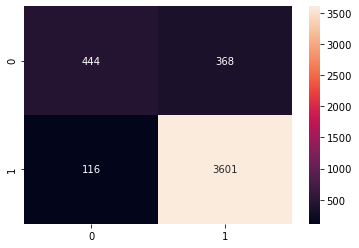

In [95]:
cnf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cnf_matrix, annot=True, fmt="d")

In [96]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.55      0.65       812
           1       0.91      0.97      0.94      3717

    accuracy                           0.89      4529
   macro avg       0.85      0.76      0.79      4529
weighted avg       0.89      0.89      0.89      4529



In [97]:
# There is not a significant difference between TF-IDF and Count Vectorizer for SVM in this case.

In [98]:
# Random Forest Classifier with Count Vectorizer

In [107]:
model = RandomForestClassifier(n_jobs=-1)

In [108]:
model.fit(X_train_count, y_train)

RandomForestClassifier(n_jobs=-1)

In [109]:
rf_count_acc = cross_val_score(model, X_test_count, y_test, cv=10).mean()

In [110]:
rf_count_acc

0.8423518724726016

In [111]:
y_pred = model.predict(X_test_count)

<AxesSubplot:>

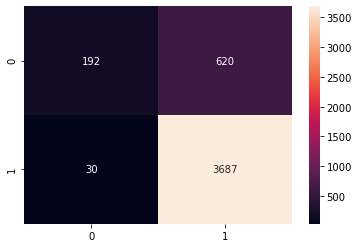

In [112]:
cnf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cnf_matrix, annot=True, fmt="d")

In [113]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.86      0.24      0.37       812
           1       0.86      0.99      0.92      3717

    accuracy                           0.86      4529
   macro avg       0.86      0.61      0.65      4529
weighted avg       0.86      0.86      0.82      4529



In [114]:
# Random Forest with Count Vectorizer did not perform well in classifying 0 values. Maybe I should tune the hyperparameters and try again.

In [115]:
# Random Forest with TF-IDF Vectorizer

In [116]:
model = RandomForestClassifier(n_jobs=-1)

In [117]:
model.fit(X_train_tf_idf, y_train)

RandomForestClassifier(n_jobs=-1)

In [118]:
rf_tf_acc = cross_val_score(model, X_test_tf_idf, y_test, cv=10).mean()

In [119]:
rf_tf_acc

0.8368292015862782

In [120]:
y_pred = model.predict(X_test_tf_idf)

<AxesSubplot:>

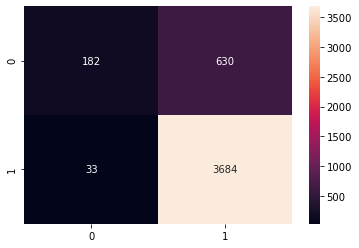

In [121]:
cnf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cnf_matrix, annot=True, fmt="d")

In [122]:
rf_tf_f1 = f1_score(y_test, y_pred, average="weighted")

In [124]:
rf_tf_f1

0.8165025757128209

In [125]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.85      0.22      0.35       812
           1       0.85      0.99      0.92      3717

    accuracy                           0.85      4529
   macro avg       0.85      0.61      0.64      4529
weighted avg       0.85      0.85      0.82      4529



In [139]:
# Ada Boost with Count Vectorizer

In [128]:
model = AdaBoostClassifier()

In [129]:
model.fit(X_train_count, y_train)

AdaBoostClassifier()

In [130]:
ada_count_acc = cross_val_score(model, X_test_count, y_test, cv=10).mean()

In [131]:
ada_count_acc

0.8595762761530799

In [132]:
y_pred = model.predict(X_test_count)

<AxesSubplot:>

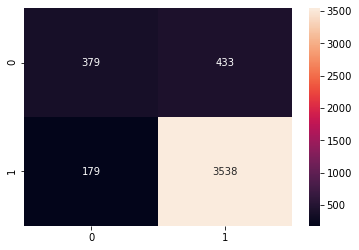

In [133]:
cnf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cnf_matrix, annot=True, fmt="d")

In [134]:
ada_count_f1 = f1_score(y_test, y_pred, average="weighted")

In [135]:
ada_count_f1

0.8545764925507396

In [136]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.68      0.47      0.55       812
           1       0.89      0.95      0.92      3717

    accuracy                           0.86      4529
   macro avg       0.79      0.71      0.74      4529
weighted avg       0.85      0.86      0.85      4529



In [138]:
# AdaBoost with TF-IDF Vectorizer

In [137]:
model = AdaBoostClassifier()

In [140]:
model.fit(X_train_tf_idf, y_train)

AdaBoostClassifier()

In [141]:
ada_tf_acc = cross_val_score(model, X_test_tf_idf, y_test, cv=10).mean()

In [142]:
ada_tf_acc

0.8567035886616265

In [145]:
y_pred = model.predict(X_test_tf_idf)

<AxesSubplot:>

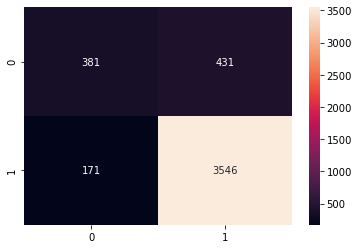

In [146]:
cnf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(cnf_matrix, annot=True, fmt="d")

In [147]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.69      0.47      0.56       812
           1       0.89      0.95      0.92      3717

    accuracy                           0.87      4529
   macro avg       0.79      0.71      0.74      4529
weighted avg       0.86      0.87      0.86      4529



In [153]:
# Let's compare cross validation accuracies of our models and visualize them.

In [149]:
compare = pd.DataFrame({"Model": ["Log Count Acc", "Log TF Acc", "NB Count Acc", "NB TF Acc",
                                 "SVM Count Acc", "SVM TF Acc", "RF Count Acc", "RF TF Acc",
                                 "Ada Count Acc", "Ada TF Acc"],
                       "CV Score": [log_count_acc, log_tf_acc, nb_count_acc, nb_tf_acc,
                                   svm_count_acc, svm_tf_acc, rf_count_acc, rf_tf_acc,
                                   ada_count_acc, ada_tf_acc]})

In [151]:
compare = compare.sort_values(by="CV Score", ascending=True)

Text(0.5, 1.0, 'Cv Score of Models')

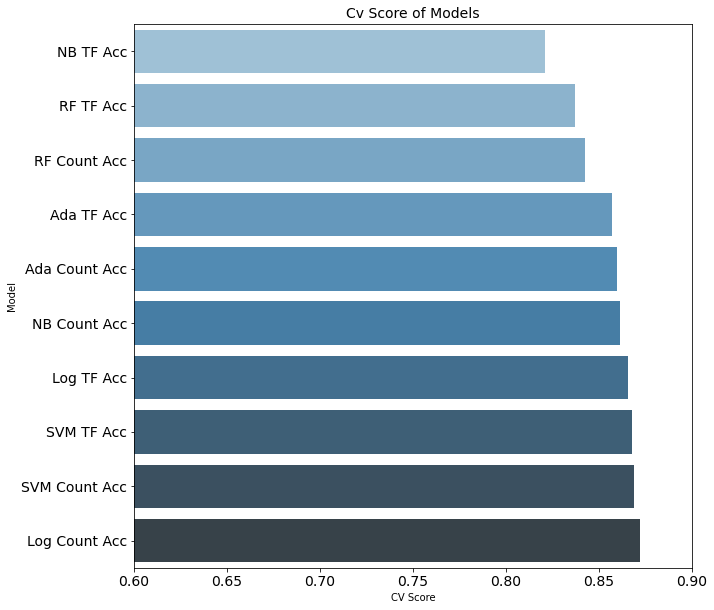

In [152]:
plt.figure(figsize=(10, 10))
ax = sns.barplot(x="CV Score", y="Model", data=compare, palette="Blues_d")
ax.set_xlim(.60, .90)
plt.yticks(size=14)
plt.xticks(size=14)
plt.title("Cv Score of Models", size=14)